# Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#from tqdm import tqdm
from tqdm.notebook import tqdm

from torchviz import make_dot

from torchmetrics import Recall, Precision, F1Score

# Create Dataset and Dataloader Objects for MNIST

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, data_file, label_file, transform=None):
        # Load the data and labels from the CSV files
        self.data = np.loadtxt(data_file, delimiter=',')
        self.labels = np.loadtxt(label_file, delimiter=',', dtype=np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Convert the numpy arrays to PyTorch tensors
        image = torch.tensor(self.data[index], dtype=torch.float32).reshape(1, 28, 28)  # reshaping to 1x28x28, 1 canal, comprimento e altura em pixeis 
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[index], dtype=torch.int64)
        return image, label

In [4]:
# Load training and testing data
X_train_path = os.path.join('data/MNIST_Original/mnist_train_data.csv')
y_train_path = os.path.join('data/MNIST_Original/mnist_train_labels.csv')
X_test_path = os.path.join('data/MNIST_Original/mnist_test_data.csv')
y_test_path = os.path.join('data/MNIST_Original/mnist_test_labels.csv')

train_dataset = MNISTDataset(X_train_path, y_train_path)
test_dataset = MNISTDataset(X_test_path, y_test_path)

C:\Users\JoaoViegas\AppData\Local\Temp\ipykernel_12416\3920772127.py:5: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  self.labels = np.loadtxt(label_file, delimiter=',', dtype=np.int64)


In [5]:
batch_size = 4  # you can change this value based on your requirements

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #é indiferente o shuffle estar a true ou false

## Torch Datasets

Represents a Dataset in pytorch. Defines `__getitem__()` and `__len__()`.
- `__getitem__()`: How to access a single data point
- `__len__()`: size of the dataset

## Torch DataLoader

Wraps a `Dataset` object and provides utilities for batching, shuffling, and parallel data loading. 

It abstracts the complexity of batching and shuffling, providing a clean and efficient way to loop through your dataset in manageable chunks.


----

Let's see what an example of a batch looks like

In [7]:
batch_data = next(iter(trainloader))
X, y = batch_data[0], batch_data[1]

X.shape
y

torch.Size([4, 1, 28, 28])

tensor([3, 8, 1, 9])

Our input is a matrix with 4 dimensions!

1. 1st dimension (4): number of images in this batch
2. 2nd dimension (1): Number of color channels (only one because images are in grey scale)
3. 3rd dimension (28): height of image, in pixels
4. 4th dimension (28): width of image, in pixels

What does an image look like?

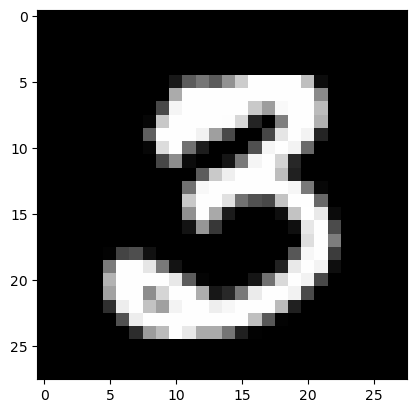

In [8]:
image_to_show = X[0].squeeze()  # Remove the channel dimension, resulting in [28, 28]
plt.imshow(image_to_show, cmap='gray')
plt.show()

pretty cool right? Let's make this into a function for future reference

In [9]:
def plot_image(image : torch.Tensor):
    plt.imshow(image, cmap='gray')
    plt.show()

# Let's build our first CNN Model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.fc1 = nn.Linear(320, 50) # 320 = 20 * 4 * 4
        self.fc2 = nn.Linear(50, 10) # DNN > WNN; also 10 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1) #para a soma de todos os componentes dar 1, basicamente é normalizar
        return x

model = SimpleCNN()


Is there a way we can visualize this model?

In [14]:
x = torch.randn(1, 1, 28, 28)  # A dummy input tensor to pass through the model
y = model(x)

dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
dot.render('model details/model_visualization', format='png')

'model details\\model_visualization.png'

Training loop

In [15]:
# Step 1: Define the model
model = SimpleCNN()

# Step 2: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #usar este ou o Adam (otimiza o step size aka learning rate?? e torna-o variavel)

# Step 3: Training Loop
num_epochs = 10
for epoch in tqdm(list(range(num_epochs))):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward
        loss = criterion(outputs, labels)  # calculate loss
        loss.backward()  # backward
        optimizer.step()  # optimize
        
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2000] loss: 0.787
[1,  4000] loss: 0.599
[1,  6000] loss: 0.463
[1,  8000] loss: 0.430
[1, 10000] loss: 0.445
[1, 12000] loss: 0.754
[1, 14000] loss: 1.160
[2,  2000] loss: 1.207
[2,  4000] loss: 0.773
[2,  6000] loss: 1.402
[2,  8000] loss: 1.843


KeyboardInterrupt: 

Feel free to interrupt training if you feel like the model is not improving anymore

A few points:

1. Why are we only evaluating every 2000th batch?
    - Because it takes time to evaluate a model, if we compute the loss everytime we update the model it would take a lot longer to train

In [16]:
# Step 4: Evaluation

# What's the loss on the train set?
total_loss = []
with torch.no_grad():
    for data in tqdm(trainloader):
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward
        loss = criterion(outputs, labels)  # calculate loss
        total_loss.append(loss.item())
print('Loss on the train set: %.3f' % (sum(total_loss) / len(total_loss)))


# What's the loss on the test set?
total_loss = []
with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward
        loss = criterion(outputs, labels)  # calculate loss
        total_loss.append(loss.item())
print('Loss on the test set: %.3f' % (sum(total_loss) / len(total_loss)))

  0%|          | 0/15000 [00:00<?, ?it/s]

Loss on the train set: 1.689


  0%|          | 0/2500 [00:00<?, ?it/s]

Loss on the test set: 1.672


Ok might be overfitting a bit but it's not too bad. Now let's look at more interesting metrics like recall and precision.

For these metrics we require the model decisions, but our current model returns only the logits (the output of the last Linear Layer). So let's run this over a softmax.

In [17]:
recall = Recall(task='multiclass',num_classes=10)
precision = Precision(task='multiclass',num_classes=10)
f1 = F1Score(task='multiclass',num_classes=10)

with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        #optimizer.zero_grad()  # zero the parameter gradients (redundante aqui)
        outputs = model(inputs)  # forward
        
        predictions = torch.argmax(outputs, dim=1)

        recall.update(predictions, labels) #update guarda os valores anteriores e os novos
        precision.update(predictions, labels)
        f1.update(predictions, labels)

print('Recall on the test set: %.2f' % (recall.compute()))
print('Precision on the test set: %.2f' % (precision.compute()))
print('F1 Score on the test set: %.2f' % (f1.compute()))

  0%|          | 0/2500 [00:00<?, ?it/s]

Recall on the test set: 0.41
Precision on the test set: 0.41
F1 Score on the test set: 0.41


# Want to save a model?

Saving models is very useful:
1. share with others
2. don't have to train again next time
3. Create model checkpoints to:
    - prevent loss from interruption
    - limited access to computing resources
    - debugging

In [18]:
# save pytorch model
torch.save(model.state_dict(), 'models/model.pt')

# How to load a model?

In [19]:
# read pytorch model
model = SimpleCNN()
model.load_state_dict(torch.load('models/model.pt'))

<All keys matched successfully>

is this model still good at prediction?

In [20]:
recall = Recall(task='multiclass',num_classes=10)
precision = Precision(task='multiclass',num_classes=10)
f1 = F1Score(task='multiclass',num_classes=10)

with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward
        
        predictions = torch.argmax(outputs, dim=1)

        recall.update(predictions, labels)
        precision.update(predictions, labels)
        f1.update(predictions, labels)

print('Recall on the test set: %.2f' % (recall.compute()))
print('Precision on the test set: %.2f' % (precision.compute()))
print('F1 Score on the test set: %.2f' % (f1.compute()))

  0%|          | 0/2500 [00:00<?, ?it/s]

Recall on the test set: 0.41
Precision on the test set: 0.41
F1 Score on the test set: 0.41


Awesome!

----

Now we could package some of this code

In [23]:
def dataloader_evaluation(model, dataloader, criterion):
    """
    Our custom evaluation of a model for this particular task and dataset.
    """

    recall = Recall(task='multiclass',num_classes=10)
    precision = Precision(task='multiclass',num_classes=10)
    f1 = F1Score(task='multiclass',num_classes=10)

    total_loss = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs, labels = data
            outputs = model(inputs)  # forward
            loss = criterion(outputs, labels)  # calculate loss
            total_loss.append(loss.item())

            predictions = torch.argmax(outputs, dim=1)
            recall.update(predictions, labels)
            precision.update(predictions, labels)
            f1.update(predictions, labels)

    average_loss = sum(total_loss) / len(total_loss)
                
    return {'loss':average_loss, 
            'recall':recall.compute().item(), 
            'precision':precision.compute().item(), 
            'f1':f1.compute().item()}

In [24]:
dataloader_evaluation(model,testloader,criterion)

  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 1.671946665647061,
 'recall': 0.4101000130176544,
 'precision': 0.4101000130176544,
 'f1': 0.4101000130176544}

Let's do the same for the training part

In [25]:
def train_one_epoch(model, dataloader, criterion, optimizer, print_every=2000):
    """
    Our custom evaluation of a model for this particular task and dataset.
    """
    running_loss = []
    for i, data in tqdm(enumerate(dataloader, 0)):
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward
        loss = criterion(outputs, labels)  # calculate loss
        loss.backward()  # backward
        optimizer.step()  # optimize

        running_loss.append(loss)

        if i % print_every == print_every-1:  # print every 2000 mini-batches
            print('[%5d] loss: %.3f' % (i + 1, loss.item()))
    return torch.mean(loss).item()

In [26]:
train_one_epoch(model, trainloader, criterion, optimizer)

0it [00:00, ?it/s]

[ 2000] loss: 2.212
[ 4000] loss: 1.102
[ 6000] loss: 2.494
[ 8000] loss: 0.642
[10000] loss: 0.977
[12000] loss: 1.979
[14000] loss: 2.326


1.5875835418701172

Great! So now we can do:

In [27]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in tqdm(list(range(2))):
    train_one_epoch(model, trainloader, criterion, optimizer)
    evaluation = dataloader_evaluation(model, testloader, criterion)
    print('Epoch %d: loss=%.3f, recall=%.2f, precision=%.2f, f1=%.2f' % (epoch+1, evaluation['loss'], evaluation['recall'], evaluation['precision'], evaluation['f1']))

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[ 2000] loss: 0.067
[ 4000] loss: 0.222
[ 6000] loss: 0.546
[ 8000] loss: 0.594
[10000] loss: 3.314
[12000] loss: 0.602
[14000] loss: 0.027


0.16640156507492065

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1: loss=0.589, recall=0.85, precision=0.85, f1=0.85


0it [00:00, ?it/s]

[ 2000] loss: 0.631
[ 4000] loss: 2.308
[ 6000] loss: 2.278
[ 8000] loss: 2.251
[10000] loss: 2.324
[12000] loss: 2.306
[14000] loss: 2.265


2.3326752185821533

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2: loss=2.302, recall=0.12, precision=0.12, f1=0.12
